In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
import numpy as np

In [2]:
file = open('../data/raw/articles.txt', 'r', encoding = 'utf8')

In [3]:
#articles.txt is a file containing article records, one record per row, column definition is:
columns = ["pubId", "is_hourly", "seqId", "on_homepage", "canonicalUrl",
                   "firstScrape", "lang_iso", "lang_reliability", "title", "text"]
articles_dt = file.read().split('\n')[:-1]

In [4]:
pubId, canonicalUrl,firstScrape,title,text,lang_reliability = [],[],[],[],[],[]
for article in articles_dt:    
    row = article.split('\t')
    pubId.append(row[0])
    canonicalUrl.append(row[4])
    firstScrape.append(row[5])
    lang_reliability.append(row[7])
    title.append(row[8])
    text.append(row[9])
articles_df = pd.DataFrame()

In [5]:
articles_df['pubId'], articles_df['canonicalUrl'], articles_df['firstScrape'], articles_df['title'], articles_df['text'], articles_df['lang_reliability']= pubId, canonicalUrl,firstScrape,title,text,lang_reliability

In [6]:
articles_df.shape

(213605, 6)

In [7]:
#exclude the lang_reliability = 0 which the detected language is not reliable
articles_df = articles_df[articles_df['lang_reliability'] == '1']
articles_df.shape

(211577, 6)

In [8]:
## text normzalization
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a paragrapy
        
        return: modified initial string
    """
    text = re.sub(r"[^\w\s]", '', text) ## Remove all non-word characters (everything except numbers and letters)
    text = text.lower() # lowercase text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords from text
    return text
    
articles_df['text'] = articles_df['text'].apply(clean_text)

In [9]:
articles_df['text']

0         phoenix capita jul 19 2018 849 government plan...
1         phoenix capita jul 19 2018 849 government plan...
2         knave dave jul 18 2018 111 pm exactly first st...
3         knave dave jul 18 2018 111 pm exactly first st...
4         phoenix capita jul 19 2018 849 government plan...
                                ...                        
213600    george sad embarrassing wreck man george sad e...
213601    manchester aldermen give courtblocked rezoning...
213602    girl 5 found asleep loaded gun deplorable cond...
213603    search advanced search old home day shine goff...
213604    foxwoods 301 home race ben lynch foxwoods 301 ...
Name: text, Length: 211577, dtype: object

In [10]:
## word embedding -GloVe
# load GloVe 
embeddings_index = {}
f = open('../data/embedding/glove.6B/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [11]:
embeddings_index['cat']

array([ 0.23088  ,  0.28283  ,  0.6318   , -0.59411  , -0.58599  ,
        0.63255  ,  0.24402  , -0.14108  ,  0.060815 , -0.7898   ,
       -0.29102  ,  0.14287  ,  0.72274  ,  0.20428  ,  0.1407   ,
        0.98757  ,  0.52533  ,  0.097456 ,  0.8822   ,  0.51221  ,
        0.40204  ,  0.21169  , -0.013109 , -0.71616  ,  0.55387  ,
        1.1452   , -0.88044  , -0.50216  , -0.22814  ,  0.023885 ,
        0.1072   ,  0.083739 ,  0.55015  ,  0.58479  ,  0.75816  ,
        0.45706  , -0.28001  ,  0.25225  ,  0.68965  , -0.60972  ,
        0.19578  ,  0.044209 , -0.31136  , -0.68826  , -0.22721  ,
        0.46185  , -0.77162  ,  0.10208  ,  0.55636  ,  0.067417 ,
       -0.57207  ,  0.23735  ,  0.4717   ,  0.82765  , -0.29263  ,
       -1.3422   , -0.099277 ,  0.28139  ,  0.41604  ,  0.10583  ,
        0.62203  ,  0.89496  , -0.23446  ,  0.51349  ,  0.99379  ,
        1.1846   , -0.16364  ,  0.20653  ,  0.73854  ,  0.24059  ,
       -0.96473  ,  0.13481  , -0.0072484,  0.33016  , -0.1236

In [14]:
# Use mean of the word embedding for each corpus
embedding_matrix = []
def Glove_Embedding(text):
    words_list = text.split(' ')
    #The dimension of the matrix is 10 0 because the glove embedding vector sizes I used is 100.
    article_sum = [0]*100
    print(article_sum)
    for word in words_list:
        if word in embeddings_index:
            word_embedding_vector = embeddings_index.get(word)
            article_sum += word_embedding_vector
    #create a corpus matrix  = mean of all the words embeddings
    article_embedd = np.asarray(article_sum)/len(words_list)    
    embedding_matrix.append(article_embedd)    

In [ ]:
articles_df['text'].apply(Glove_Embedding)

In [18]:
#matrix shape = len of the aritles * 100
embedding_matrix = np.asarray(embedding_matrix)
embedding_matrix.shape

(211577, 100)

In [19]:
embedding_matrix[-1]

array([ 0.00602137,  0.01195719,  0.22523276, -0.24457395, -0.0119647 ,
       -0.08792708,  0.08966452,  0.23945617, -0.3218343 , -0.08691979,
        0.24135602, -0.0707292 ,  0.06616067, -0.11020071, -0.08192461,
       -0.1166989 ,  0.18551545,  0.10917941, -0.19468354,  0.20750614,
        0.21419556,  0.08076224,  0.15277111,  0.06879448,  0.14427054,
       -0.10953973, -0.17506241, -0.25021611,  0.10026254, -0.06295393,
       -0.28487296,  0.30291189, -0.07665823,  0.00793329,  0.08361133,
        0.14716428, -0.15557311,  0.20291562, -0.06152896,  0.1046313 ,
       -0.11874123, -0.2363765 ,  0.09580593, -0.16065576, -0.15009723,
        0.04664021,  0.10279823, -0.26585508,  0.0926819 , -0.51392792,
       -0.1201345 , -0.20157663, -0.01180393,  0.56009289,  0.02124097,
       -1.51099883, -0.22494964,  0.09388035,  0.86499679,  0.29900739,
       -0.18096338,  0.39167915, -0.0059991 ,  0.06502863,  0.4097549 ,
       -0.04531584,  0.10152085,  0.21511926,  0.04947853,  0.08

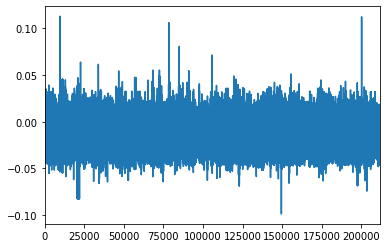

In [22]:
pd.DataFrame(embedding_matrix).mean(axis = 1).plot()

In [23]:
pd.DataFrame(embedding_matrix).to_csv("../data/embedding/Glove_embedding_output.csv")

In [56]:
## cosine similiarty bettween each articles
from sklearn.metrics.pairwise import cosine_similarity
def get_cosine_sim(m): 
    length = m.shape[0]
    cos_sim_matrix = np.empty([length, length])
    for i in range(length):
        for j in range(length):
    return cos_sim_matrix


In [ ]:
art_sim = get_cosine_sim(embedding_matrix)